# Brownian motion

Een van de bekendste voorbeelden van botsende deeltjes in de natuur is Brownian motion.
Fijn gemalen pollen in water lijken te dansen in willekeurige richting.
Dit komt doordat de pollen worden geraakt door watermoleculen die in alle richtingen bewegen.
Omdat de pollen veel zwaarder zijn dan watermoleculen, dus de beweging van de pollen is veel langzamer en minder "intens" dan die van de watermoleculen.
Dit proces van willekeurige beweging door botsingen met kleinere deeltjes wordt Brownian motion genoemd en kunnen we simuleren op basis van ons (premature) botsingsmodel.
Daarbij kunnen we ook gebruik maken van de zojuist geleerde manier van tracking van deeltjes, waarbij we een zowel het zware bolletjes als een enkel deeltje kunnen volgen.

Let op!
We bestuderen hier nog geen thermische effecten, deze opdrachten zijn met name bedoeld om beter te begrijpen hoe het botsingsmodel in elkaar zit.

```{warning}
In dit notebook zitten delen waar ruimte is om code toe te voegen, maar waarbij je denkt... waarom dan?
In een latere opdracht moet je terug naar die cell en de juiste code toevoegen.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Maken van de ParticleClass

class ParticleClass:
    # Het maken van het deeltje
    def __init__(self, m, v, r, R, c):
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = np.array(R, dtype=float)  
        self.c = c # kleur van het deeltje

    # Het updaten van de positie, eventueel met zwaartekracht
    def update_position(self):
        self.r += self.v * dt #+ 1/2 * a * dt**2  
              
    # Harde wand
    def boxcollision(self):
        if abs(self.r[0]) + self.R > Box_length: 
            self.v[0] = -self.v[0]                                  # Omdraaien van de snelheid
            self.r[0] = np.sign(self.r[0]) * (Box_length - self.R)  # Zet terug net binnen box          
        if abs(self.r[1]) + self.R > Box_length: 
            self.v[1] = -self.v[1]     
            self.r[1] = np.sign(self.r[1]) * (Box_length - self.R)
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)

In [3]:
# Aanmaken van de randvoorwaarden en initiele condities
Box_size_0 = 10
Box_length_0 = Box_size_0/2
Box_length = Box_length_0     # De grootte van de box kan wijzigen!

# Particles
dt = 0.04
particles = []
N = 40
v_0 = 1

# Aanmaken van deeltjes
for i in range(N-1):
    vx = np.random.uniform(-v_0,v_0)
    vy = np.random.choice([-1, 1])*np.sqrt(v_0**2-vx**2)        
    pos = Box_length_0*np.random.uniform(-1,1,2)
    particles.append(ParticleClass(m=1.0, v=[vx, vy], r = pos, R=.5,c='blue')) 

# Een zwaar deeltje in het midden met geen snelheid
particles.append(ParticleClass(m=20.0, v=[0, 0], r = [0, 0], R=.5,c='red')) 

```{exercise} Brownian motion
:label: ex-brownian-1

Leg uit wat er in de laatste regel van bovenstaande script gebeurt.
Voeg voor deze regel goede metadata toe.
```

```{solution} ex-brownian-1
Het voegt nog een deeltje toe met een veel grotere massa dan de anderen in particles, dit is waarschijnlijk de pol die we zullen simuleren.
```

Er is een doos vol met deeltjes op willekeurige positie aangemaakt.
We willen kijken waar de deeltjes zijn terechtgekomen.
Hieronder staat dit weergegeven. 



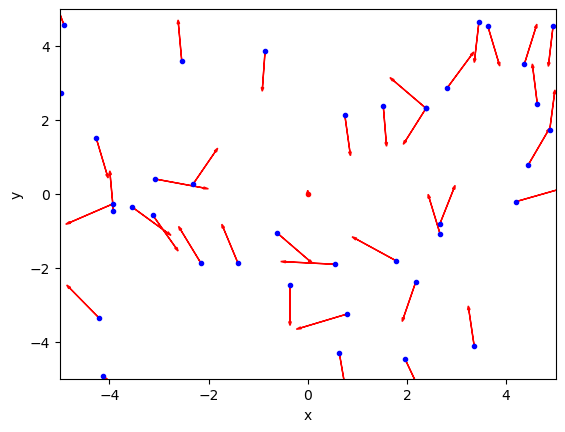

In [4]:
# Inspecteren van beginsituatie
plt.figure()

plt.xlabel('x')
plt.ylabel('y')

plt.xlim(-Box_length_0,Box_length_0)
plt.ylim(-Box_length_0,Box_length_0)

# Plotten van deeltjes en snelheidsvectoren
for particle, particle_object in enumerate(particles):
    plt.plot(particle_object.r[0],particle_object.r[1],color=particle_object.c,marker='.')
    plt.arrow(particle_object.r[0],particle_object.r[1], 
               particle_object.v[0],particle_object.v[1], 
               head_width=0.05, head_length=0.1, color='red')
plt.show()


```{exercise} 
:label: ex-brownian-2

Er staat ook code met comments ervoor, wat doet deze code? 
Check je antwoord door de comments weg te halen.
Hoe wordt er voor gezorgd dat de snelheid van elk deeltje gelijk is?
```

```{solution} ex-brownian-2
Het geeft aan hoe ver en waar het deeltje gaat na een tijdstap. De snelheid wordt voor elk deeltje bepaald door een willekeurige snelheid in de x-richting tussen -V_0 en V_0, waarmee de bijbehorende vy wordt berekent doordat V_0 de gekozen snelheid is.
```

We gaan nu de functies van de simulatie weer aanroepen:

In [5]:
# Het bepalen of er een botsing plaats vindt
def collide_detection(self, other):
    dx = self.r[0] - other.r[0]
    dy = self.r[1] - other.r[1]
    rr = self.R + other.R
    return  dx**2+dy**2 < rr**2 
        
def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

def handle_collisions(particles):
#your code/answer
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    global aant_bots
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])
                aant_bots += 1
#your code/answer


In onderstaande code geven we de code voor de simulatie en volgen we de positie van het zware deeltje. 

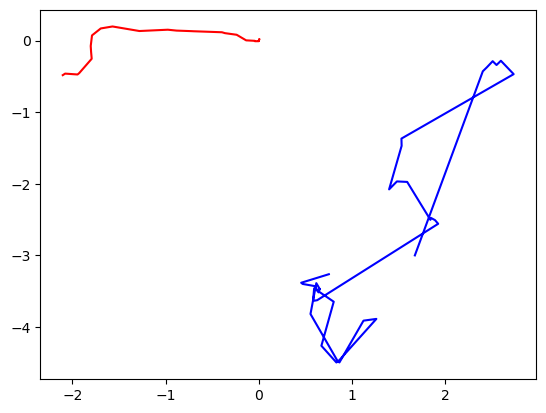

In [6]:
# tracken van het zware deeltje
track_x_zd = []
track_y_zd = []

# tracken van het lichte deeltje
track_x_ld = []
track_y_ld = []

# Aantal botsingen per tijdstap
botsingen = [0]

#your code/answer

#your code/answer

#your code/answer

for i in range(400):
#your code/answer
    aant_bots = 0

    for p in particles:
        p.update_position()    # Update positie        
        p.boxcollision()         # Wandbotsing werkt per deeltje
   
    handle_collisions(particles)  # Onderlinge botsingen afhandelen
    botsingen.append(botsingen[-1] + aant_bots)

#your code/answer
    track_x_ld.append(particles[0].r[0])
    track_y_ld.append(particles[0].r[1])
    track_x_zd.append(particles[N-1].r[0])
    track_y_zd.append(particles[N-1].r[1])
    
#your code/answer

plt.figure()
plt.plot(track_x_zd,track_y_zd,'r')
#your code/answer
plt.plot(track_x_ld,track_y_ld,'b')
plt.show()

```{exercise} Brownian motion in beeld
:label: ex-brownian-3
- Draai de onderstaande simulatie een keer en bestudeer de output.
- Voeg zelf een tweede tracking toe van een licht deeltje en verbeter de plot.
- Wat zijn overeenkomsten en verschillen tussen de beweging van de twee deeltjes?
- Wat valt je op als je de simulatie een aantal keer runt?
```

```{solution} ex-brownian-3
De beweging van het licht deeltje gaat veel makkelijker een andere kant op dan die van het zware deeltje, omdat het een veel kleinere massa heeft. Ook heeft het licht deeltje een veel grotere pad afgelegd dan de zware, doordat het een beginsnelheid heeft die constant blijft zolang het niet in contact komt met het zware deeltje.
```

We zouden gevoel willen krijgen voor het aantal botsingen dat per tijdseenheid plaatsvindt. 
Elke keer dat er een botsing plaatsvindt, zou de counter met 1 omhoog moeten gaan.
Idealiter wordt het aantal botsingen opgeslagen in een array zodat je het aantal botsingen als functie van de tijd kunt weergeven.

```{exercise}
Pas bovenstaand idee toe in de eerder gemaakte code.
Plot hieronder het aantal botsingen als functie van de tijd.
```

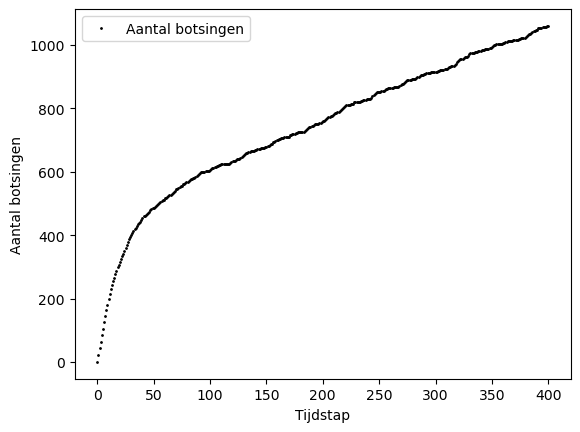

In [7]:
#your code/answer
plt.figure()
plt.plot(botsingen, 'k.', markersize=2, label='Aantal botsingen')
plt.legend()
plt.xlabel('Tijdstap')
plt.ylabel('Aantal botsingen')
plt.show()

```{warning} 🌶 Let op!
:icon: false
De onderstaande opdrachten vallen buiten de stof maar tellen mee als je excellent wilt behalen.
```

In zulke fysica modellen is de afgelegde weg (afstand tussen begin en eindpunt) van belang.
Deze afgelegde weg zegt iets over de snelheid van difussie.
Idealiter bekijken we een histogram.
Maar voor een histogram hebben we veel deeltjes nodig.



```{exercise} Afgelegde weg 🌶
:label: ex-brownian-4

- Maak een simulatie met 361 deeltjes, waarvan 1 zwaar deeltje.
- Houd rekening met de boxgrootte, deze moet mee schalen!
- Maak een histogram van de afgelegde weg voor alle deeltjes. 
- Geef de afgelegde weg van het grote deeltje duidelijk aan.
```


In [8]:
#your code/answer
# Aanmaken van de randvoorwaarden en initiele condities
Box_360_size_0 = 90
Box_360_length_0 = Box_360_size_0/2
Box_360_length = Box_360_length_0     # De grootte van de box kan wijzigen!

# Particles
dt = 0.1
deeltjes = []
N_360 = 360
v_0 = 1

dt = 0.04

# Aanmaken van deeltjes
for i in range(N_360-1):
    vx = np.random.uniform(-v_0,v_0)
    vy = np.random.choice([-1, 1])*np.sqrt(v_0**2-vx**2)        
    pos = Box_360_length_0*np.random.uniform(-1,1,2)
    deeltjes.append(ParticleClass(m=1.0, v=[vx, vy], r = pos, R=.5,c='blue')) 

# Een zwaar deeltje in het midden met geen snelheid
deeltjes.append(ParticleClass(m=20.0, v=[0, 0], r = [0, 0], R=.5,c='red')) 

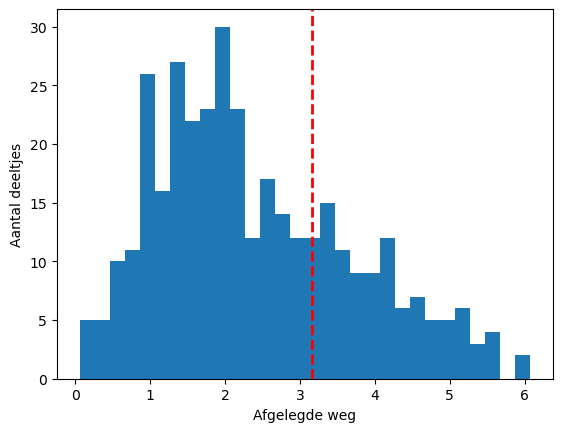

In [14]:
# tracken van het lichte deeltje
bpunt = []
epunt = []
afg_weg = []
for deeltje in range(N_360):
    bpunt.append(deeltjes[deeltje].r.copy())


for i in range(400):

    for p in deeltjes:
        p.update_position()    # Update positie        
        p.boxcollision()         # Wandbotsing werkt per deeltje
   
    handle_collisions(deeltjes)  # Onderlinge botsingen afhandelen

for deeltje in range(N_360):
    epunt.append(deeltjes[deeltje].r.copy())


for i in range(N_360-1):
    b_tot_e = epunt[i] - bpunt[i]
    afg_weg.append(np.sqrt(np.dot(b_tot_e, b_tot_e)))

d_zw = epunt[N_360-1] - bpunt[N_360-1]
afg_zw = np.sqrt(np.dot(d_zw, d_zw))


plt.figure()
plt.hist(afg_weg, bins=30)
plt.axvline(afg_zw, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Afgelegde weg')
plt.ylabel('Aantal deeltjes')
plt.show()

En nu we toch bezig zijn met twee verschillende deeltjes.... 

We kunnen twee "groepen" van deeltjes aanmaken, elk  met een andere massa. Als we dan de zwaartekracht aan zetten, dan zouden we verwachten dat de lichtere deeltjes boven komen "drijven".

```{exercise} Onderzoek dit vermoeden 🌶
- maak daartoe de box 2x zo hoog als breed
- verdubbel het totaal aantal deeltjes
- zet een artificieel grote zwaartekracht aan
```

In [10]:
# Maken van de ParticleClass

class ParticleClass2:
    # Het maken van het deeltje
    def __init__(self, m, v, r, R, c):
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = np.array(R, dtype=float)  
        self.c = c # kleur van het deeltje
        self.a = np.array([0, -500])  # Zwaartekracht

    # Het updaten van de positie, eventueel met zwaartekracht
    def update_position(self):
        self.r += self.v * dt + 1/2 * self.a * dt**2
              
    # Harde wand
    def boxcollision(self):
        if abs(self.r[0]) + self.R > Box_g_length/2: 
            self.v[0] = -self.v[0]                                  # Omdraaien van de snelheid
            self.r[0] = np.sign(self.r[0]) * (Box_g_length/2 - self.R)  # Zet terug net binnen box          
        if abs(self.r[1]) + self.R > Box_g_length: 
            self.v[1] = -self.v[1]     
            self.r[1] = np.sign(self.r[1]) * (Box_g_length - self.R)
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)

In [11]:
#your code/answer
# Aanmaken van de randvoorwaarden en initiele condities
Box_g_size_0 = 90
Box_g_length_0 = Box_g_size_0/2
Box_g_length = Box_g_length_0     # De grootte van de box kan wijzigen!

# Particles
dt = 0.1
l_deeltjes = [] # lichte deeltjes
z_deeltjes = [] # zware deeltjes
N_360 = 360
v_0 = 10

# Aanmaken van lichte deeltjes
for i in range(N_360-1):
    vx = np.random.uniform(-v_0,v_0)
    vy = np.random.choice([-1, 1])*np.sqrt(v_0**2-vx**2)        
    pos = Box_g_length_0*np.random.uniform(-1,1,2)
    l_deeltjes.append(ParticleClass2(m=1.0, v=[vx, vy], r = pos, R=.5,c='blue')) 

# Aanmaken van zware deeltjes
for i in range(N_360-1):
    vx = np.random.uniform(-v_0,v_0)
    vy = np.random.choice([-1, 1])*np.sqrt(v_0**2-vx**2)        
    pos = Box_g_length_0*np.random.uniform(-1,1,2)
    z_deeltjes.append(ParticleClass2(m=20.0, v=[vx, vy], r = pos, R=.5,c='red')) 

particles = np.concatenate((l_deeltjes, z_deeltjes))

In [12]:
def take_time_step(particles):
    for p in particles:
        p.update_position()
        p.boxcollision()
        
    handle_collisions(particles) 

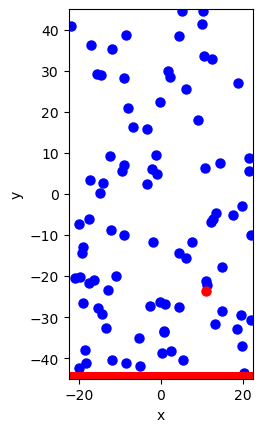

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-Box_g_length/2, Box_g_length/2)
ax.set_ylim(-Box_g_length, Box_g_length)
ax.set_aspect('equal')
l_dot, = ax.plot([], [], 'b.', ms=13);
z_dot, = ax.plot([], [], 'r.', ms=13);

def init():
    l_dot.set_data([], [])
    z_dot.set_data([], [])
    return l_dot, z_dot,

def update(frame):

    take_time_step(particles)
    l_dot.set_data([p.r[0] for p in l_deeltjes], [p.r[1] for p in l_deeltjes])
    z_dot.set_data([p.r[0] for p in z_deeltjes], [p.r[1] for p in z_deeltjes])
    return l_dot, z_dot,

ani = FuncAnimation(fig, update, frames=100, init_func=init, blit=True, interval=50)
HTML(ani.to_jshtml())